In [ ]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.1/298.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

Text(0, 0.5, 'strain')

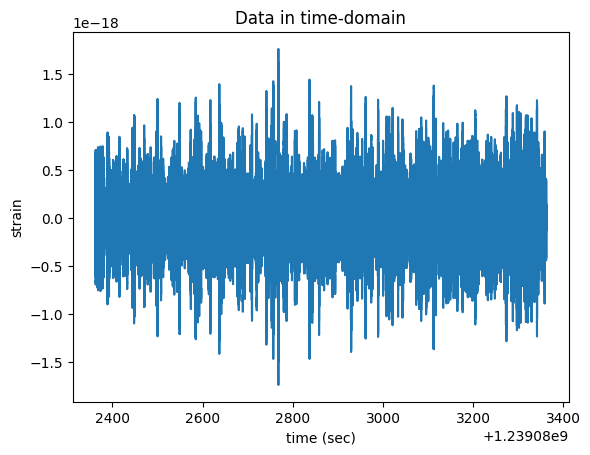

In [ ]:
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt

d = np.load('/content/noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d
plt.plot(time, data)
plt.title('Data in time-domain')
plt.xlabel('time (sec)')
plt.ylabel('strain')




Text(0.5, 1.0, 'Noise power spectral density')

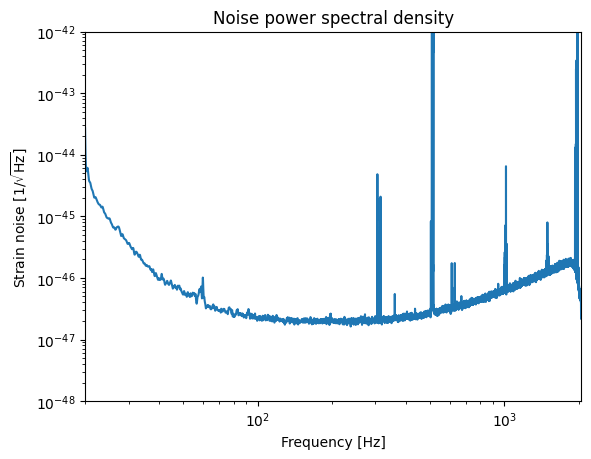

In [10]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

sampling_rate = 1/d.delta_t

# Conditioning data to avoid input wraparound

conditioned = d.crop(2,2)

# Calculation of PSD:
psdc = conditioned.psd(4)
psdc = interpolate(psdc, conditioned.delta_f)

psdc = inverse_spectrum_truncation(psdc, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=20)

plotpsdc = psdc.plot()

# To make sure plotpsdc is a single plot object, not a list
if isinstance(plotpsdc, list):
    plotpsdc = plotpsdc[0]

# Access the current figure and its axis
fig = plotpsdc.figure
ax = fig.gca()
# Limit frequency from 20 Hz up to Nyquist frequency
ax.set_xlim(20, 0.5*sampling_rate)
ax.set_xlim(20, )
ax.set_xlabel('Frequency [Hz]')
ax.set_xscale('log')
ax.set_ylim(1e-48, 1e-42)
ax.set_yscale('log')
ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.set_title('Noise power spectral density')


Some spikes are clearly visible in the plotted PSD, some or most of which have been introduced to calibrate the detector.

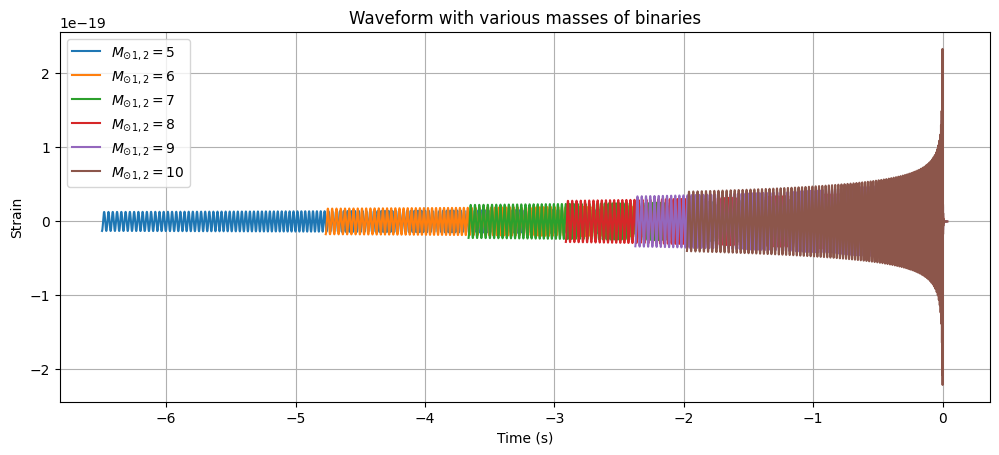

In [11]:
from pycbc.waveform import get_td_waveform
import pylab

# Generate waveform template assuming that GW signals can produce only from equal mass binary systems with a range between 5 to 10
# This allows for searching for a specific signal in noisy data

pylab.figure(figsize=pylab.figaspect(0.4))
for m in [5,6,7,8,9,10]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)

    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title('Waveform with various masses of binaries')
pylab.show()

As seen in the plot above, the length of the waveform is longer for lower-mass binary systems and shorter for longer ones.


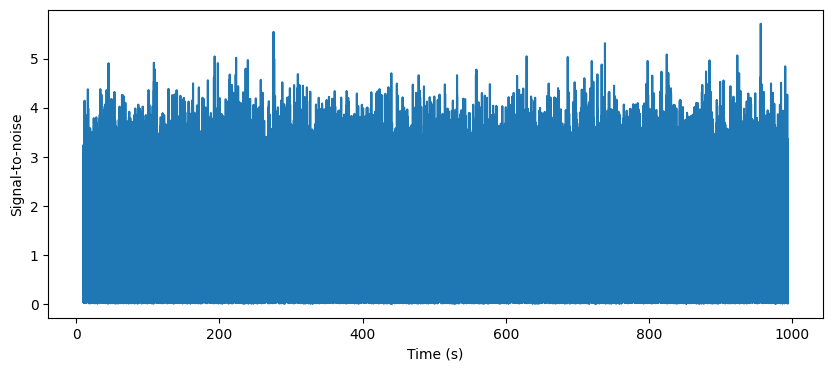

We found a signal at 956.0270996090002s with SNR 5.71366189464663


In [ ]:
from pycbc.filter import matched_filter

# Template to match the waveform with the length of conditioned data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

# SNR through matched-filtering
snr = matched_filter(template, conditioned,
                     psd=psdc, low_frequency_cutoff=20)

# Remove the time to account for the template filter and the psd filter as well as the template length
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]


print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

Since the SNR is below 8, we cannot claim to have detected a gravitational wave.

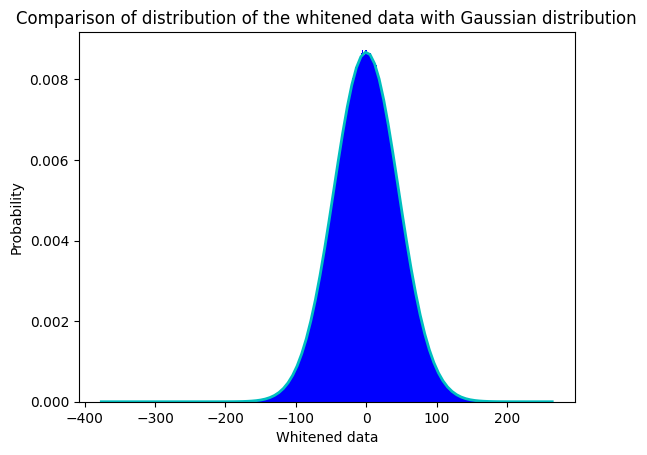

Histogram and Gaussian Fit (Mean=0.00, Standard Deviation=45.97)


In [13]:
 # Whiten data and template waveform

from pycbc.types import TimeSeries

psdc[0] = psdc[1]
psdc[len(psdc) - 1] = psdc[len(psdc) - 2]
data_whitened = (conditioned.to_frequencyseries() / psdc**0.5).to_timeseries()
data_whitened= data_whitened.crop(4,4)

from scipy.stats import norm
mean = np.mean(data_whitened)
std_dev = np.std(data_whitened)

# Plotting a histogram
plt.hist(data_whitened, bins="auto", density = True, color="b")
# Adding a Gaussian distribution for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, color='c', linewidth=2);
# Adding labels and title
plt.title("Comparison of distribution of the whitened data with Gaussian distribution")
plt.xlabel("Whitened data")
plt.ylabel("Probability")
# Display the plot
plt.show()
print(f"Histogram and Gaussian Fit (Mean={mean:.2f}, Standard Deviation={std_dev:.2f})")



The whitened data follows a Gaussian distribution with zero mean with fair accuracy.

Creating a test to see whether noise is stationary. If noise is stationary, the signal-to-noise ratio should be fixed.

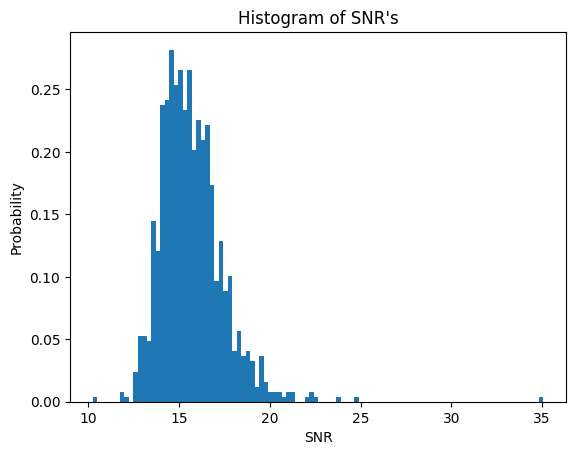

In [15]:
from pycbc.waveform import get_fd_waveform

# Generating random waveform

hp1, hc1 = get_fd_waveform(approximant="TaylorF2",
                          mass1=3,
                          mass2=3,
                          delta_f=1.0/200.0,
                          distance=500,
                          f_lower=20,
                          f_final=2048)


# Splicing data
slices = 1000
data_slice_length = len(d) // slices

snr_list = []

# Iterating over each data slice to calculate optimal SNR
for i in range(slices):
    chunk = d[i * data_slice_length: (i + 1) * data_slice_length]
    chunk_psd = pycbc.psd.interpolate(pycbc.psd.welch(chunk), hp1.delta_f)
    chunk_snr = np.sqrt(pycbc.filter.sigmasq(hp1, chunk_psd))
    snr_list.append(chunk_snr)

#Plotting the histogram
plt.hist(snr_list, 100, density=True)
plt.title("Histogram of SNR's")
plt.xlabel("SNR")
plt.ylabel("Probability")

plt.show()



The histogram indicates variation in SNR-values. Thus, the noise is not stationary.